In [2]:
from google.colab import files
uploaded = files.upload()

Saving img.zip to img.zip


In [3]:
import zipfile
import os

zip_path = '/content/img.zip'  # change this to match the uploaded filename
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')  # extract to folder

In [4]:
!unzip -o /content/img.zip -d /content/images

Archive:  /content/img.zip
  inflating: /content/images/img/segmentation-0_lesionmask_0.png  
  inflating: /content/images/img/segmentation-0_lesionmask_1.png  
  inflating: /content/images/img/segmentation-0_lesionmask_10.png  
  inflating: /content/images/img/segmentation-0_lesionmask_11.png  
  inflating: /content/images/img/segmentation-0_lesionmask_12.png  
  inflating: /content/images/img/segmentation-0_lesionmask_13.png  
  inflating: /content/images/img/segmentation-0_lesionmask_14.png  
  inflating: /content/images/img/segmentation-0_lesionmask_15.png  
  inflating: /content/images/img/segmentation-0_lesionmask_16.png  
  inflating: /content/images/img/segmentation-0_lesionmask_17.png  
  inflating: /content/images/img/segmentation-0_lesionmask_18.png  
  inflating: /content/images/img/segmentation-0_lesionmask_19.png  
  inflating: /content/images/img/segmentation-0_lesionmask_2.png  
  inflating: /content/images/img/segmentation-0_lesionmask_20.png  
  inflating: /content/im

In [5]:
image_folder = '/content/images/img'
images = [f for f in os.listdir(image_folder) if f.lower().endswith('.png')]
print(f"Total images: {len(images)}")

Total images: 611


In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import cv2
import glob

# Load CSV files
df_train = pd.read_csv('/content/lits_train.csv')
df_test = pd.read_csv('/content/lits_test.csv')

# Folder where images are stored
image_folder = '/content/images/img'  # <-- Change to your folder path
dataset_paths = sorted(glob.glob(os.path.join(image_folder, '*.png')))

# Define the load_images function
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img.shape != (128, 128):
            img = cv2.resize(img, (128, 128))
        images.append(img)
    return np.array(images).reshape(-1, 128, 128, 1)

# Load dataset
X = load_images(dataset_paths)
X = X / 255.0

# Extract labels
y = df_train['tumor_mask_empty'].values[:len(X)]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# CNN model
inputs = Input(shape=(128, 128, 1))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

cnn_model = Model(inputs=inputs, outputs=outputs)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=4, validation_split=0.2)
# Extract CNN features
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# XGBoost on CNN features
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train_features, y_train.ravel())
y_pred = xgb_model.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost Accuracy: {accuracy:.4f}')

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9312 - loss: 0.5801 - val_accuracy: 0.9592 - val_loss: 0.2819
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9493 - loss: 0.2550 - val_accuracy: 0.9592 - val_loss: 0.1771
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9499 - loss: 0.2154 - val_accuracy: 0.9592 - val_loss: 0.1621
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9360 - loss: 0.2682 - val_accuracy: 0.9592 - val_loss: 0.1581
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9522 - loss: 0.2437 - val_accuracy: 0.9592 - val_loss: 0.2143
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9559 - loss: 0.2804 - val_accuracy: 0.9592 - val_loss: 0.1778
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9607 - loss: 0.1858 - val_accuracy: 0.9592 - val_loss: 0.1771
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9637 - loss: 0.1512 - val_accuracy: 0.9592 - v

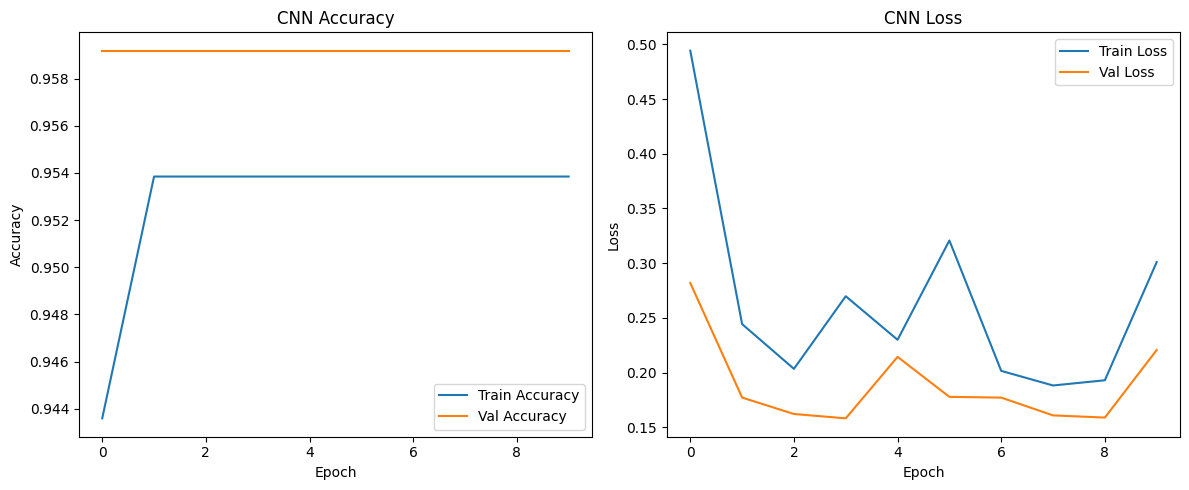

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

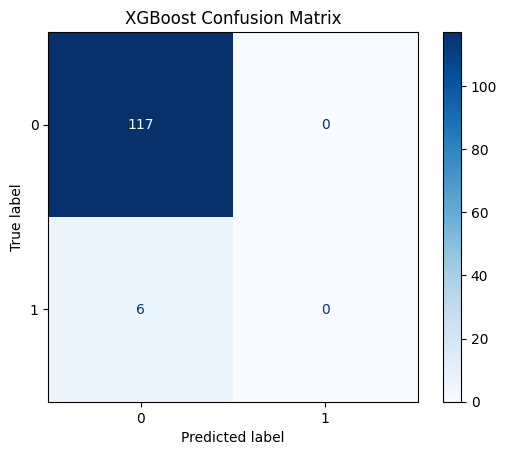

In [8]:
#Confusion Matrix for XGBoost
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

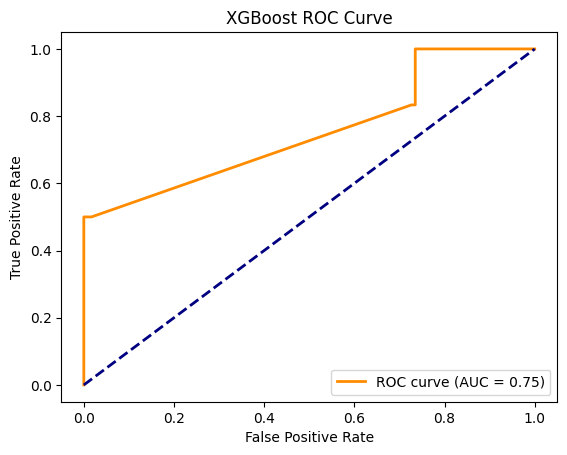

In [9]:
#ROC Curve for XGBoost
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_probs = xgb_model.predict_proba(X_test_features)[:, 1]

# Compute ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
feature_extractor.save('/content/feature_extractor_model.h5')

In [11]:
feature_extractor = tf.keras.models.load_model('/content/feature_extractor_model.h5')

In [12]:
# Save your trained models (you should have already done this)
feature_extractor.save('/content/feature_extractor_model.h5')

import joblib
joblib.dump(xgb_model, '/content/xgb_model.pkl')

['/content/xgb_model.pkl']

In [13]:
!pip install streamlit pyngrok xgboost opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 133.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00


In [14]:
import os
os.environ["NGROK_AUTHTOKEN"] = "2jobd681TGhlxwJLHtUfB2JfBrp_7BBJHimf3bV2aJyti3B5K"

In [15]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import cv2
import glob
import os
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers, Input
from xgboost import XGBClassifier
import joblib

# Load trained models (you must save them after training in Colab)
cnn_model = load_model('/content/feature_extractor_model.h5')
xgb_model = joblib.load('/content/xgb_model.pkl')

# Feature extractor
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

def load_image(image_file):
    img = cv2.imdecode(np.frombuffer(image_file.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    return img.reshape(1, 128, 128, 1) / 255.0

st.title("Tumor Detection using CNN + XGBoost")

uploaded_file = st.file_uploader("Upload an image", type=['png', 'jpg', 'jpeg'])
if uploaded_file is not None:
    st.image(uploaded_file, caption='Uploaded Image', width=250)
    img = load_image(uploaded_file)

    cnn_features = feature_extractor.predict(img)
    prediction = xgb_model.predict(cnn_features)[0]
    st.write("Prediction:", "Tumor Detected" if prediction == 1 else "No Tumor")

Writing app.py


In [16]:
!streamlit run app.py &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.87.177.179:8501

  Stopping...


In [17]:
import streamlit as st
import numpy as np
import cv2
import tensorflow as tf
import pickle

# Load models
cnn_model = tf.keras.models.load_model('/content/feature_extractor_model.h5')  # Make sure this file exists
with open("/content/xgb_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)  # XGBoost model on CNN features

st.title("Liver Tumor Detection from CT Scan")

uploaded_file = st.file_uploader("Upload a Liver CT Scan Image", type=["png", "jpg", "jpeg"])

if uploaded_file is not None:
    # Display image
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_GRAYSCALE)

    # Preprocess
    img_resized = cv2.resize(img, (128, 128))
    img_input = img_resized.reshape(1, 128, 128, 1) / 255.0

    st.image(img, caption="Uploaded CT Scan", use_container_width=True)

    # Feature extraction from CNN
    feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)
    cnn_features = feature_extractor.predict(img_input)

    # XGBoost Prediction
    prediction = xgb_model.predict(cnn_features)[0]
    label = "Tumor Detected" if prediction == 1 else "No Tumor Found"

    # Display result
    st.success(f"Prediction: {label}")

2025-05-04 05:11:19.397 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 05:11:19.880 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-04 05:11:19.884 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 05:11:19.886 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 05:11:19.887 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 05:11:19.890 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 05:11:19.892 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 05:11:19.892 Thread 'MainThread': mi

In [18]:
!pip install streamlit pyngrok pillow

In [19]:
!ngrok config add-authtoken 2w5cMSLJWZtB20oKypL38j8uJgj_7Ets2As4UPW5udBCnKJoY

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [20]:
# Install required packages
!pip install streamlit pyngrok pillow

# Write the Streamlit app to a file
code = """
import streamlit as st
from PIL import Image
import numpy as np

def predict_tumor(image_array):
    return "Tumor Detected" if np.mean(image_array) < 100 else "No Tumor Detected"

st.title("Liver Cancer Detection from CT Scans")
st.write("Upload a CT scan image to detect presence of liver tumor.")

uploaded_file = st.file_uploader("Choose a CT scan image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert('L')  # grayscale
    st.image(image, caption="Uploaded CT Image", use_column_width=True)

    image_resized = image.resize((224, 224))
    image_array = np.array(image_resized)

    prediction = predict_tumor(image_array)
    st.subheader("Prediction:")
    st.success(prediction)
    """
with open("app.py", "w") as f:
    f.write(code)

In [ ]:
# Start ngrok
from pyngrok import ngrok
ngrok.kill()
public_url = ngrok.connect(8501)
print(f"Public URL: {public_url}")

# Run Streamlit app
!streamlit run app.py --server.enableCORS false --server.enableXsrfProtection false &

Public URL: NgrokTunnel: "https://942b-34-87-177-179.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.87.177.179:8501

